In [1]:
from forse.networks.dcgan import *
import matplotlib.pyplot as plt
from forse.tools import *

Using TensorFlow backend.


In [2]:
dcgan = DCGAN(output_directory='/global/homes/k/krach/scratch/NNforFG/DCGAN/opt', img_size=(64, 64))

In [3]:
training_path = '/global/homes/k/krach/scratch/NNforFG/training_set/'
training_file = 'training_set_1000patches_20x20deg_T_HR1deg_LR5deg_Npix64_lat20.npy'
patch_file = training_path+training_file
dcgan.train(epochs=5000, patches_file=patch_file, batch_size=32, save_interval=1000, seed=3875)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Training Data Shape:  (800, 64, 64, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1092353   
Total params: 2,184,322
Trainable params: 1,091,969
Non-trainable params: 1,092,353
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


/usr/common/software/tensorflow/gpu-tensorflow/1.13.1-py36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0
200/200 [==============================] - 0s 183us/step
[0.5807226061820984, 0.995] [0.7222570872306824, 0.08]
1000
200/200 [==============================] - 0s 174us/step
[0.4293146800994873, 1.0] [1.0584217357635497, 0.0]
2000
200/200 [==============================] - 0s 178us/step
[0.4630468440055847, 1.0] [0.9948229336738587, 0.0]
3000
200/200 [==============================] - 0s 175us/step
[0.32499996066093445, 1.0] [1.2804192781448365, 0.0]
4000
200/200 [==============================] - 0s 176us/step
[0.23526751041412353, 1.0] [1.568862361907959, 0.0]


In [19]:
def smooth_accuracy(y_true, y_pred):
        return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [20]:
dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/opt/lat20/models/'
dcgan.discriminator = load_model(dir_models+'discrim_15000.h5', custom_objects={'smooth_accuracy': smooth_accuracy})
dcgan.generator = load_model(dir_models+'generat_15000.h5', custom_objects={'smooth_accuracy': smooth_accuracy})

In [4]:
dir_models = '/global/homes/k/krach/scratch/NNforFG/DCGAN/tests/ratio/models/pswap_10/'
dcgan.discriminator = load_model(dir_models+'discrim_99999.h5')
dcgan.generator = load_model(dir_models+'generat_99999.h5')

/usr/common/software/tensorflow/gpu-tensorflow/1.13.1-py36/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [21]:
X_train, X_test, Y_train, Y_test = load_training_set(training_path+training_file, seed=1235)
gen_imgs_test = dcgan.generator.predict(X_test)
gen_imgs_train = dcgan.generator.predict(X_train)

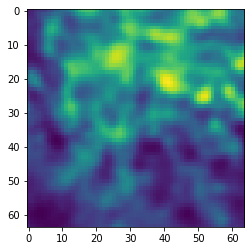

In [22]:
plt.imshow(gen_imgs_test[14, :, :, 0])

In [23]:
print(dcgan.discriminator.evaluate(gen_imgs_test, np.zeros(len(gen_imgs_test))))
print(dcgan.discriminator.evaluate(Y_test, np.ones(len(gen_imgs_test))))
print(dcgan.discriminator.predict(Y_test[0:10]))
print(dcgan.discriminator.predict(gen_imgs_test[0:10]))

200/200 [==============================] - 1s 3ms/step
[0.06415615737438202, 1.0]
200/200 [==============================] - 0s 206us/step
[2.782241926193237, 0.0]
[[0.05714846]
 [0.06010842]
 [0.06419629]
 [0.06637952]
 [0.06659725]
 [0.06217727]
 [0.05767006]
 [0.06258473]
 [0.06745706]
 [0.06498551]]
[[0.0638662 ]
 [0.06121889]
 [0.0606291 ]
 [0.06597561]
 [0.0606896 ]
 [0.05862856]
 [0.06901968]
 [0.06437418]
 [0.06937346]
 [0.06401864]]


In [9]:
val = dcgan.discriminator.evaluate(Y_test, np.ones(len(gen_imgs_test)))

200/200 [==============================] - 0s 203us/step


In [10]:
print(val)

[4.97561653137207, 0.0]


In [11]:
val = dcgan.discriminator.evaluate(gen_imgs_test, np.zeros(len(gen_imgs_test)))
print(val)

200/200 [==============================] - 0s 197us/step
[0.00819761399179697, 1.0]


In [12]:
batch_size = 32
half_batch = batch_size // 2
ind_batch = np.random.randint(0, X_train.shape[0], batch_size)
idx = np.random.randint(0, X_train.shape[0], half_batch)
imgs = Y_train[idx]
idx = np.random.randint(0, X_train.shape[0], half_batch)
gen_imgs = dcgan.generator.predict(X_train[idx])
target_real = np.ones((half_batch, 1))
target_fake = np.zeros((half_batch, 1))
dcgan.discriminator.trainable=False
d_loss_real = dcgan.discriminator.test_on_batch(imgs, target_real)
d_loss_fake = dcgan.discriminator.test_on_batch(gen_imgs, target_fake)

In [13]:
val = dcgan.discriminator.evaluate(gen_imgs_test, np.zeros(len(gen_imgs_test)))
print(val)

200/200 [==============================] - 0s 203us/step
[0.00819761399179697, 1.0]


In [14]:
d_loss_real = dcgan.discriminator.train_on_batch(imgs, target_real)
print(d_loss_real, dcgan.discriminator.evaluate(imgs, target_real))
d_loss_fake = dcgan.discriminator.train_on_batch(gen_imgs, target_fake)
print(d_loss_fake, dcgan.discriminator.evaluate(gen_imgs, target_fake))
d_loss_real = dcgan.discriminator.test_on_batch(imgs, target_real)
d_loss_fake = dcgan.discriminator.test_on_batch(gen_imgs, target_fake)

16/16 [==============================] - 0s 264us/step
[3.6499815, 0.0] [1.2441191673278809, 0.4375]
16/16 [==============================] - 0s 238us/step
[0.12970498, 1.0] [0.33273419737815857, 0.875]


In [15]:
val = dcgan.discriminator.evaluate(Y_test, np.ones(len(gen_imgs_test)))
print(val)

200/200 [==============================] - 0s 200us/step
[1.3739714241027832, 0.37]


In [16]:
val = dcgan.discriminator.evaluate(gen_imgs_test, np.zeros(len(gen_imgs_test)))
print(val)

200/200 [==============================] - 0s 202us/step
[0.3279931089282036, 0.825]


In [17]:
print(dcgan.discriminator.predict(Y_test[0:10]))
print(dcgan.discriminator.predict(gen_imgs_test[0:6]))

[[0.17726797]
 [0.07036072]
 [0.6384798 ]
 [0.86451197]
 [0.22291681]
 [0.54710656]
 [0.2626378 ]
 [0.5647286 ]
 [0.68569225]
 [0.34892017]]
[[0.45363125]
 [0.37314457]
 [0.01217267]
 [0.17214519]
 [0.12201146]
 [0.01411968]]
